In [189]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import haversine
plt.rcParams['figure.figsize'] = (6,5)

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
data = pd.read_csv("../Dataset/scaledN.csv")

In [191]:
data.head()

,Latitude,Longitude,Scaled N
0,17.895,73.401,0.63157
1,17.895,73.401,0.65262
2,17.895,73.402,0.39998
3,17.895,73.404,0.82105
4,17.895,73.404,0.88421


In [192]:
data.corr()

,Latitude,Longitude,Scaled N
Latitude,1.000000,0.189321,0.283999
Longitude,0.189321,1.000000,0.080928
Scaled N,0.283999,0.080928,1.000000


In [193]:
data  = data.rename(columns ={'Longitude':'lon', 'Latitude':'lat', 'Scaled N':'N'})
data.head()

,lat,lon,N
0,17.895,73.401,0.63157
1,17.895,73.401,0.65262
2,17.895,73.402,0.39998
3,17.895,73.404,0.82105
4,17.895,73.404,0.88421


## Data PreProcessing

In [194]:
data.shape

(25806, 3)

In [195]:
#drop duplicates rows
data.drop_duplicates(subset=['lat', 'lon'], inplace = True)
data = data.reset_index(drop = True)
data.head()

,lat,lon,N
0,17.895,73.401,0.63157
1,17.895,73.402,0.39998
2,17.895,73.404,0.82105
3,17.895,73.405,0.58946
4,17.895,73.406,0.88421


In [196]:
data.shape

(23194, 3)

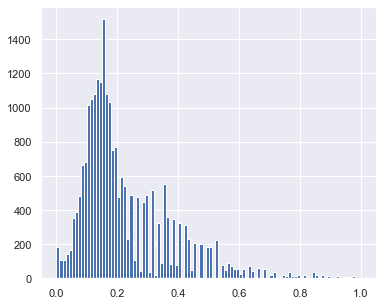

In [197]:
data['N'].hist(bins = 100)
plt.show()

<AxesSubplot:xlabel='N'>

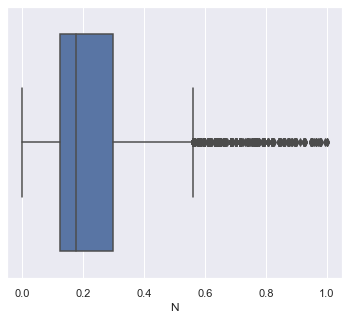

In [198]:
sns.boxplot('N',data = data)

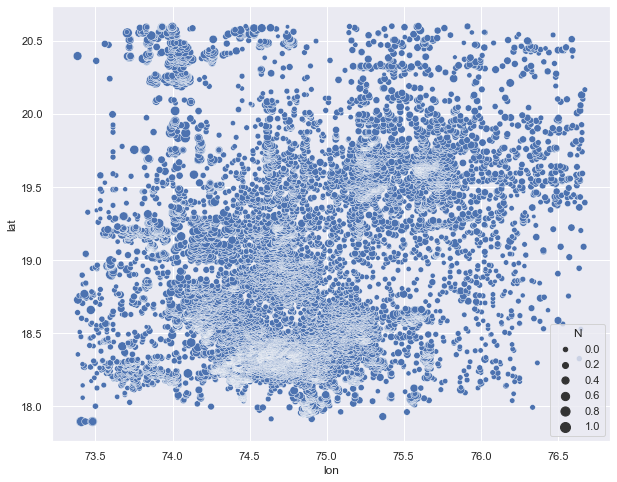

In [199]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x ='lon', y ='lat',size ='N',sizes =(20, 100), data = data)
plt.show()

## Exploratory Data Analysis

In [200]:
from haversine import haversine, Unit
## Data points conversion
def Haversine(df):
  res = []
  ref_points = (df['lat'][0], df['lon'][0])
  for i in range(df.shape[0]):
    latlon = (df['lat'][i], df['lon'][i])
    dist = haversine(ref_points, latlon)
    res.append(dist*1000)
  return res


In [201]:
data_exp = data.copy()
res = Haversine(data_exp)

data_exp['haversine'] = res

In [202]:
data_exp.head()

,lat,lon,N,haversine
0,17.895,73.401,0.63157,0.000000
1,17.895,73.402,0.39998,105.815598
2,17.895,73.404,0.82105,317.446794
3,17.895,73.405,0.58946,423.262393
4,17.895,73.406,0.88421,529.077991


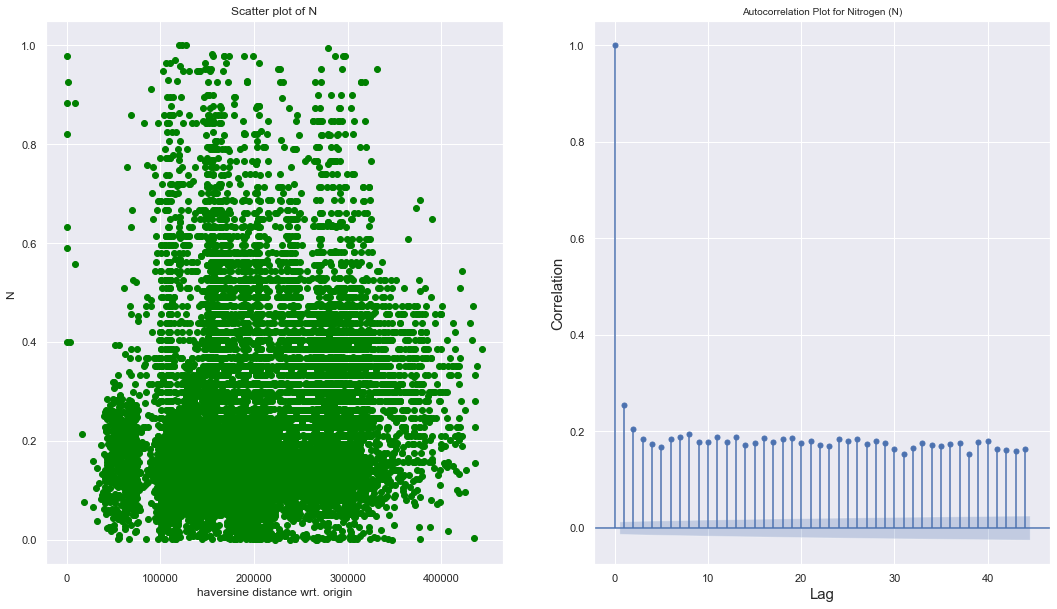

In [203]:
# check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
green = sns.color_palette("deep", 8)[2]
blue = sns.color_palette("deep", 8)[0]
sns.set()

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(121)
plt.scatter(x = data_exp['haversine'], y = data_exp['N'], color='green')
plt.title("Scatter plot of N")
plt.xlabel("haversine distance wrt. origin")
plt.ylabel("N ")

ax2 = fig.add_subplot(122)
plot_acf(data_exp["N"], ax=ax2,color=blue)
plt.title("Autocorrelation Plot for Nitrogen (N)", fontsize=10)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.show()

<AxesSubplot:xlabel='N', ylabel='Count'>

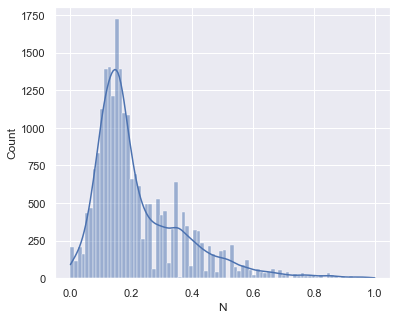

In [204]:
# # check for Normality assumptions
sns.histplot(x = 'N', data = data_exp, kde =True)

 data is not normally distributed.

In [205]:
# Skewness check
data_exp['N'].skew()

1.5995827915134244

In [206]:
# data_exp['N'].values.min()

In [207]:
# # lets try to bring it to its closest normal distribution by box-cox transformation
from scipy.special import inv_boxcox
from scipy.stats import boxcox
data_exp.drop(data[data['N'] == 0.0].index, inplace=True)
val, lambda_ =  boxcox(data_exp['N'].values)
data_exp['N'] = val

In [208]:
# let's verify whether skewness has decreased or not
data_exp['N'].skew()

0.09094078510039329

There has been significant decrease in skewness of the data from `1.5` to `0.09`

[]

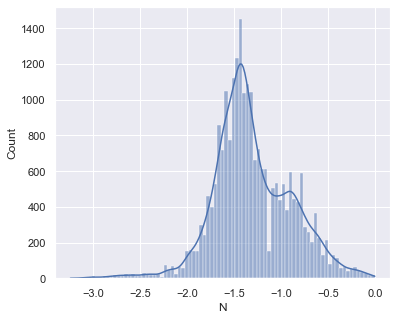

In [209]:
# # verify it with KDE plot
sns.histplot(x = 'N', data = data_exp, kde =True)
plt.plot()

In [210]:
# check for stationarity of the data
#unit root test (Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

adf_test  = adfuller(list(data_exp['N']))
print(f"test statistics: {adf_test[0]}, p value: {adf_test[1]}")


test statistics: -8.356505374166467, p value: 2.8995092226522323e-13


Sinece the pval is less that 0.05, with 95% confidence interval, we reject the null hypothesis. Thus there is stationarity amomg the data

## Ordinary krigging

In [31]:
from pykrige.ok import OrdinaryKriging

In [45]:
data1 = data_exp.copy()
ix = np.random.choice(data1.shape[0],int(data1.shape[0]*0.3),replace = False)
data_train = data1.iloc[[int(i) for i in range(data1.shape[0]) if i not in ix]].reset_index(drop = True)
data_test = data1.iloc[ix].reset_index(drop = True)

In [46]:
data_train.shape, data_test.shape

((16235, 4), (6957, 4))

## Neural Process

In [277]:
df = data_exp.copy()
# res = Haversine(df)

# df['haversine'] = res
df.head()

,lat,lon,N,haversine
0,17.895,73.401,-0.429770,0.000000
1,17.895,73.402,-0.802977,105.815598
2,17.895,73.404,-0.191549,317.446794
3,17.895,73.405,-0.489419,423.262393
4,17.895,73.406,-0.120855,529.077991


In [278]:
def calculate_kneighbors(df, k):
  res = []
  ref = df['haversine'].values
  ref = np.sort(ref)
  # print(ref[0:2])
  for el in df['haversine'].values:
    index = np.where(ref==el)
    if k+index[0][0] > len(df)-1:
      temp = ref[index[0][0]-k:]

    if index[0][0]-k < 0:
      temp = ref[index[0][0]:index[0][0]+k+1]

    else:
      # print(index[0][0]-k)
      temp = ref[index[0][0]-k:index[0][0]+k+1]

    temp = np.abs(temp-el)
    temp = np.sort(temp)
    res.append(temp[k]+el)

  return res

  

In [279]:
one_nbr = calculate_kneighbors(df, 1)
two_nbr = calculate_kneighbors(df, 2)
three_nbr = calculate_kneighbors(df, 3)
four_nbr = calculate_kneighbors(df, 4)
five_nbr = calculate_kneighbors(df, 5)

In [280]:
df['NBR_1'] = one_nbr
df['NBR_2'] = two_nbr
df['NBR_3'] = three_nbr
df['NBR_4'] = four_nbr
df['NBR_5'] = five_nbr

In [281]:
df.head()

,lat,lon,N,haversine,NBR_1,NBR_2,NBR_3,NBR_4,NBR_5
0,17.895,73.401,-0.429770,0.000000,105.815598,317.446794,423.262393,529.077991,634.893589
1,17.895,73.402,-0.802977,105.815598,211.631196,423.262393,529.077991,634.893589,846.524785
2,17.895,73.404,-0.191549,317.446794,423.262393,529.077991,634.893589,846.524785,3491.914734
3,17.895,73.405,-0.489419,423.262393,529.077991,529.077991,634.893589,3491.914734,8465.247787
4,17.895,73.406,-0.120855,529.077991,634.893589,634.893589,740.709187,846.524785,8571.063383


In [282]:
df.corr()

,lat,lon,N,haversine,NBR_1,NBR_2,NBR_3,NBR_4,NBR_5
lat,1.000000,0.213038,0.255719,0.782133,0.782140,0.782156,0.782162,0.782171,0.782183
lon,0.213038,1.000000,0.141445,0.752298,0.752302,0.752296,0.752300,0.752300,0.752297
N,0.255719,0.141445,1.000000,0.285297,0.285297,0.285312,0.285310,0.285312,0.285338
haversine,0.782133,0.752298,0.285297,1.000000,1.000000,0.999999,0.999998,0.999997,0.999996
NBR_1,0.782140,0.752302,0.285297,1.000000,1.000000,0.999999,0.999999,0.999998,0.999997
NBR_2,0.782156,0.752296,0.285312,0.999999,0.999999,1.000000,1.000000,0.999999,0.999998
NBR_3,0.782162,0.752300,0.285310,0.999998,0.999999,1.000000,1.000000,1.000000,0.999999
NBR_4,0.782171,0.752300,0.285312,0.999997,0.999998,0.999999,1.000000,1.000000,0.999999
NBR_5,0.782183,0.752297,0.285338,0.999996,0.999997,0.999998,0.999999,0.999999,1.000000


In [283]:
df.head()

,lat,lon,N,haversine,NBR_1,NBR_2,NBR_3,NBR_4,NBR_5
0,17.895,73.401,-0.429770,0.000000,105.815598,317.446794,423.262393,529.077991,634.893589
1,17.895,73.402,-0.802977,105.815598,211.631196,423.262393,529.077991,634.893589,846.524785
2,17.895,73.404,-0.191549,317.446794,423.262393,529.077991,634.893589,846.524785,3491.914734
3,17.895,73.405,-0.489419,423.262393,529.077991,529.077991,634.893589,3491.914734,8465.247787
4,17.895,73.406,-0.120855,529.077991,634.893589,634.893589,740.709187,846.524785,8571.063383


In [284]:
#do some more preprocessing
# col = [ 'NBR_1', 'NBR_2', 'NBR_3', 'NBR_4', 'NBR_5']
# for c in col:
#   df[c] = (df[c] - int(df[c].min())) #convert distance into meters

In [285]:
# df = df.sample(frac = 1).reset_index(drop =True)
# df.head()

In [286]:
df.shape

(23192, 9)

In [287]:
# df['N'] = (df['N'] - df['N'].min())/(df['N'].max()-df['N'].min())
# df.head()

In [288]:
# # 
col = ['lat', 'lon']
df[col] = df[col]*100

In [289]:
df.corr()

,lat,lon,N,haversine,NBR_1,NBR_2,NBR_3,NBR_4,NBR_5
lat,1.000000,0.213038,0.255719,0.782133,0.782140,0.782156,0.782162,0.782171,0.782183
lon,0.213038,1.000000,0.141445,0.752298,0.752302,0.752296,0.752300,0.752300,0.752297
N,0.255719,0.141445,1.000000,0.285297,0.285297,0.285312,0.285310,0.285312,0.285338
haversine,0.782133,0.752298,0.285297,1.000000,1.000000,0.999999,0.999998,0.999997,0.999996
NBR_1,0.782140,0.752302,0.285297,1.000000,1.000000,0.999999,0.999999,0.999998,0.999997
NBR_2,0.782156,0.752296,0.285312,0.999999,0.999999,1.000000,1.000000,0.999999,0.999998
NBR_3,0.782162,0.752300,0.285310,0.999998,0.999999,1.000000,1.000000,1.000000,0.999999
NBR_4,0.782171,0.752300,0.285312,0.999997,0.999998,0.999999,1.000000,1.000000,0.999999
NBR_5,0.782183,0.752297,0.285338,0.999996,0.999997,0.999998,0.999999,0.999999,1.000000


In [290]:
data = df[['N', 'lat', 'lon']].copy()

In [291]:
norm_mean = data.mean()
norm_std = data.std()

In [292]:
#split dataset into train and test
# split the dataset into train and test dataset
ix = np.random.choice(data.shape[0],int(data.shape[0]*0.2),replace = False)
data_train = data.iloc[[int(i) for i in range(data.shape[0]) if i not in ix]].reset_index(drop = True)
data_test = data.iloc[ix].reset_index(drop = True)

In [293]:
data_train.shape, data_test.shape

((18554, 3), (4638, 3))

In [294]:
data_train.head()

,N,lat,lon
0,-0.429770,1789.5,7340.1
1,-0.802977,1789.5,7340.2
2,-0.191549,1789.5,7340.4
3,-0.489419,1789.5,7340.5
4,-0.120855,1789.5,7340.6


In [295]:
data_test.head()

,N,lat,lon
0,-0.830106,1796.0,7486.0
1,-1.134095,1863.8,7558.5
2,-1.282532,1851.7,7429.9
3,-1.100215,1971.7,7401.8
4,-1.420518,1886.2,7520.4


In [296]:
data_test.shape

(4638, 3)

In [297]:
# data_train = (data_train-norm_mean)/norm_std
# data_test = (data_test-norm_mean)/norm_std

In [298]:
data_train.head()

,N,lat,lon
0,-0.429770,1789.5,7340.1
1,-0.802977,1789.5,7340.2
2,-0.191549,1789.5,7340.4
3,-0.489419,1789.5,7340.5
4,-0.120855,1789.5,7340.6


In [299]:
data_test.head()

,N,lat,lon
0,-0.830106,1796.0,7486.0
1,-1.134095,1863.8,7558.5
2,-1.282532,1851.7,7429.9
3,-1.100215,1971.7,7401.8
4,-1.420518,1886.2,7520.4


 ## NP Model

In [300]:
class baseNPBlock(nn.Module):
    """relu non-linearities for NP block"""
    def __init__(self, inp_size,op_size, isnorm = True, bias = False, p = 0):
        """init function for linear2d class

        parameters
        ----------
        inp_size : int
                input dimension for the Encoder part (d_in)
        op_size : int
                output dimension for Encoder part(d_out)
        norm : str
                normalization to be applied on linear output
                pass norm == 'batch' to apply batch normalization
                else dropout normalization is applied
        bias : bool
                if True, bias is included for linear layer else discarded
        p : float
                probality to be considered while applying Dropout regularization
                
        """
        super().__init__()
        self.linear = nn.Linear(inp_size,op_size,bias = bias)
        self.relu  = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(inp_size)
        self.dropout = nn.Dropout2d(p)
        self.isnorm = isnorm
        
    def forward(self,x):
#         print(x.shape)
        
#         print(x.shape)
        if self.isnorm:
            x = self.batch_norm(x.permute(0,2,1)[:,:,:,None]) 
#             print(x.shape)
            x = self.dropout(x)
            x = x[:,:,:,0].permute(0,2,1)
        x = self.linear(x)
#         print(x)
        x = self.relu(x)
        return x

In [301]:
class batch_MLP(nn.Module):
    """ Batch MLP layer for NP-Encoder"""
    def __init__(self, in_size, op_size, last_op_size,  num_layers, isnorm = True, p = 0):
        """init function for linear2d class
        
        parameters
        ----------
        inp_size : int
                input dimension for the Encoder part (d_in)
        op_size : int
                output dimension for Encoder part(d_out)
        norm : str
                normalization to be applied on linear output
                pass norm == 'batch' to apply batch normalization
                else dropout normalization is applied
                
        return torch.tensor of size (B,num_context_points,d_out)
        """
        super().__init__()
        self.in_size = in_size
        self.op_size = op_size
        self.num_layers = num_layers
        self.isnorm  = isnorm
        
        self.first_layer = baseNPBlock(in_size, op_size, self.isnorm, False,p)
        self.encoder = nn.Sequential(*[baseNPBlock(op_size, op_size, self.isnorm, False, p) for layer in range(self.num_layers-2)])
        self.last_layer = nn.Linear(op_size, last_op_size )
        
    def forward(self, x):
        x = self.first_layer(x)
        x = self.encoder(x)
        x = self.last_layer(x)
        
        return x

In [302]:
class LinearAttention(nn.Module):
    def __init__(self,in_ch, out_ch):
        super().__init__()
        self.linear = nn.Linear(in_ch, out_ch, bias = False)
        torch.nn.init.normal_(self.linear.weight,std = in_ch**0.5) #initilize weight matrix
        
    def forward(self,x):
#         print("x dim =", x.shape)
        return self.linear(x)
    
    
class AttentionModule(nn.Module):
    def __init__(
        self,
        hidden_dim, 
        attn_type , 
        attn_layers,
        x_dim, 
        rep='mlp',
        n_multiheads = 8,
        isnorm = True,
        p = 0):
        
        super().__init__()
        self.rep = rep

        # rep determines whether raw input given to the model would be used as key and query or
        # it's output through MLP. 
        if self.rep =='mlp':
            
            self.batch_mlpk = batch_MLP(x_dim, hidden_dim, hidden_dim, attn_layers, isnorm ,p)
            self.batch_mlpq = batch_MLP(x_dim, hidden_dim, hidden_dim, attn_layers, isnorm, p)
        
        
        if attn_type == 'uniform':
            self.attn_func = self.uniform_attn
        if attn_type=='laplace':
            self.attn_func = self.laplace_attn
        if attn_type == 'dot':
            self.attn_func = self.dot_attn
        elif attn_type == 'multihead':
            self.w_k = nn.ModuleList([LinearAttention(hidden_dim,hidden_dim) for head in range(n_multiheads)])
            self.w_v = nn.ModuleList([LinearAttention(hidden_dim,hidden_dim) for head in range(n_multiheads)])
            self.w_q = nn.ModuleList([LinearAttention(hidden_dim,hidden_dim) for head in range(n_multiheads)])
            
            self.w = LinearAttention(hidden_dim*n_multiheads,hidden_dim)
            self.attn_func = self.multihead_attn
            self.num_heads = n_multiheads
            
            
            
    def forward(self, k, q, v):
        
        if self.rep =='mlp':
#             print("in mlp")
            k = self.batch_mlpk(k) #(B, n, H)
            q = self.batch_mlpq(q) #(B, m, H)
#         print(k.shape, q.shape, v.shape)
        rep = self.attn_func(k,q,v)
        
        return rep
    
    
    def uniform_attn(self, k, q, v):
        num_points = q.shape[1]
        rep = torch.mean(v, axis = 1, keepdim = True)
        rep = rep.repeat(1,num_points,1)
        
        return rep
    
    def laplace_attn(self, k, q, v, scale = 0.5):
        k = k.unsqueeze(1)
        v = v.unsqueeze(2)
        
        w = torch.abs((k-v)*scale)
        w = w.sum(dim = -1)
        weight = torch.softmax(w, dim = -1)
        
        #batch matrix multiplication (einstein summation convention for tensor)
        rep = torch.einsum("bik, bkj -> bij",weight, v)
        
        return rep
    
    
    def dot_attn(self, k, q, v):
#         print("k =",k.shape)
#         print("q =",q.shape)
#         print("v =",v.shape)    
        β = q.shape[-1]**0.5
        w_unnorm = torch.einsum('bjk,bik->bij', k, q)/β
#         print("w_unnorm =",w_unnorm.shape)
        
        weight = torch.softmax(w_unnorm, dim = -1)
        rep = torch.einsum("bik, bkj -> bij",weight, v)
#         print("rep =",rep.shape)
        return rep
    
    def multihead_attn(self, k , q, v):
        outs = []
        
        for i in range(self.num_heads):
#             print("k =",k.shape)
            k = self.w_k[i](k) #(B, n, H)
#             print("k =",k.shape)
            q = self.w_q[i](q) #(B, m, H)
#             print("q =",q.shape)
            v = self.w_v[i](v) #(B, n, H)
#             print("v =",v.shape)
            out = self.dot_attn(k, q, v)
            outs.append(out)
            
        outs = torch.stack(outs, dim = -1) #(B, m, H, n_heads)
#         print("outs dim =", outs.shape)
        outs = outs.view(outs.shape[0], outs.shape[1], -1) #(B, m, n_heads*H)
#         print("outs shape =",outs.shape)
        rep = self.w(outs) #(B, m, H)
        
        return rep
    
    

In [303]:
# AttentionModule?

In [304]:
class DeterministicEncoder(nn.Module):
    def __init__(
                self,
                in_dim,
                x_dim,
                isnorm = True,
                hidden_dim = 32,
                n_encoder_layer = 2,
                rep = 'mlp',
                self_attn_type ='dot',
                cross_attn_type ='dot',
                n_multiheads = 8,
                p_encoder = 0,
                p_attention = 0,
                attn_layers = 2,
                use_self_attn = False
                ):
        super().__init__()
        
        self.use_self_attn = use_self_attn
        
        self.encoder = batch_MLP(in_dim, hidden_dim, hidden_dim, n_encoder_layer,isnorm, p_encoder)
        
        if self.use_self_attn:
            self.self_attn = AttentionModule(hidden_dim, self_attn_type, attn_layers,x_dim, rep = 'identitiy',isnorm = isnorm, p = p_attention, n_multiheads = n_multiheads)
            
        self.cross_attn = AttentionModule(hidden_dim, cross_attn_type, attn_layers, x_dim, rep ='mlp', isnorm = isnorm, p = p_attention, n_multiheads = n_multiheads)
        
    
    def forward(self, context_x, context_y, target_x):
        #concatenate context_x, context_y along the last dim.
        det_enc_in = torch.cat([context_x, context_y], dim = -1)
        
        det_encoded = self.encoder(det_enc_in) #(B, n, hd)
#         print("in det 1",det_encoded.shape)
        if self.use_self_attn:
            det_encoded = self.self_attn(det_encoded, det_encoded, det_encoded) #(B, n, hd)
#         print("in det 2",det_encoded.shape)    
        h = self.cross_attn(context_x, target_x, det_encoded) #(B, n, hd)
        
        return h
        
        
    
        
        

In [305]:
class LatentEncoder(nn.Module):
    def __init__(self,
                in_dim,
                 x_dim,
                hidden_dim = 32,
                latent_dim = 32,
                self_attn_type = 'dot',
                encoder_layer = 3,
                 n_multiheads = 8,
                min_std = 0.01,
                isnorm = True,
                p_encoder = 0,
                p_attn = 0,
                use_self_attn = False,
                attn_layers = 2,
                 rep ='mlp'
                ):
        
        super().__init__()
        
        self._use_attn = use_self_attn
        
        self.encoder = batch_MLP(in_dim, hidden_dim,hidden_dim, encoder_layer,isnorm, p_encoder)
        
        if self._use_attn:
            self.self_attn = AttentionModule(hidden_dim, self_attn_type, attn_layers,x_dim, rep = rep,isnorm = isnorm, p = p_attn, n_multiheads = n_multiheads)
        
        self.secondlast_layer = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.l_sigma = nn.Linear(hidden_dim, latent_dim) 
        self.min_std = min_std
#         self.use_lvar = use_lvar
        self.use_attn = use_self_attn
        
        self.relu = torch.nn.ReLU()
        
    def forward(self,x,y):
        encoder_inp = torch.cat([x,y], dim = -1) 
#         print("encoded_in = \n",encoder_inp,"\n")
        encoded_op = self.encoder(encoder_inp)#(B, n, hd)
#         print("encoder_op shape = ",encoded_op.shape)
#         print("encoded_op = \n",encoded_op,"\n")
        if self.use_attn:
            encoded_op = self.self_attn(encoded_op, encoded_op, encoded_op) #(B, n, hd)
            
#         print("eo",encoded_op)
        mean_val = torch.mean(encoded_op, dim = 1) #mean aggregation over all the points (B, hd)
    
        #further MLP layer that maps parameters to gaussian latent
        mean_repr = self.relu(self.secondlast_layer(mean_val)) #(B, hd)
#         print(mean_repr)
        μ = self.mean(mean_repr) # (B, ld)
#         print(μ)
#         print("mean = ", μ.shape)
        log_scale = self.l_sigma(mean_repr) #(B, ld)
        
        #to avoid mode collapse
        σ = self.min_std + (1-self.min_std)*torch.sigmoid(log_scale*0.5) #(B, ld)
#         print(μ)
#         print(μ.shape)
        dist = torch.distributions.Normal(μ, σ)
        
        return dist
        
        
            

In [306]:
class Decoder(nn.Module):
    def __init__(self,
                 x_dim,
                 y_dim,
                 hidden_dim = 32,
                 latent_dim = 32,
                 n_decoder_layer = 3,
                 use_deterministic_path = True,
                 min_std = 0.01,
                 isnorm = True,
                 dropout_p = 0,
                ):
        super().__init__()
        
        self.isnorm = isnorm
        self.target_transform = nn.Linear(x_dim, hidden_dim)
        
        if use_deterministic_path:
            hidden_dim_2 = hidden_dim + latent_dim + x_dim
        else:
            hidden_dim_2 = latent_dim + x_dim
            
        self.decoder = batch_MLP(hidden_dim_2, hidden_dim_2, 2, n_decoder_layer, isnorm, dropout_p)
        
#         self.mean = nn.Linear(hidden_dim_2, y_dim)
#         self.std = nn.Linear(hidden_dim_2, y_dim)
        self.deterministic_path = use_deterministic_path
        self.min_std = min_std
        
        
    def forward(self, rep,  t_x):
#         x = self.target_transform(t_x)
        
#         if self.deterministic_path:
#             z = torch.cat([r,z], dim = -1)
# #             print("z.shape =", z.shape)
        hidden_decode = torch.cat([rep,t_x], dim = -1)
#         print("hd =",hidden_decode.shape)
        hidden_decode = self.decoder(hidden_decode)
#         print(hidden_decode.shape)
        mean, log_sigma = hidden_decode[:, : ,:1],hidden_decode[:, :, 1:] 
        
        #clamp sigmad
        sigma = self.min_std + (1 - self.min_std) * F.softplus(log_sigma)
        
        dist = torch.distributions.Normal(mean,sigma)
        
        return dist, mean, sigma

In [307]:
[123]*4 + [2]

[123, 123, 123, 123, 2]

In [308]:
class LatentModel(nn.Module):
    def __init__(self,
               x_dim,
               y_dim,
               hidden_dim = 32,
               latent_dim = 32,
               latent_self_attn_type = 'dot',
               det_self_attn_type = 'dot',
               det_cross_attn_type = 'multihead',
               n_multiheads = 8,
               n_lat_enc_layer = 2,
               n_det_enc_layer = 2,
               n_decoder_layer = 2,
               rep ='mlp',
               use_deterministic_enc = False,
               min_std = 0.01,
               p_drop = 0,
               isnorm = True,
               p_attn_drop = 0,
               attn_layers = 2,
               use_self_attn = False,
               context_in_target = True
                ):
        
        super().__init__()
        self.laten_encoder = LatentEncoder(x_dim+y_dim,
                                           x_dim,
                                           hidden_dim=hidden_dim,
                                           latent_dim=latent_dim,
                                           self_attn_type=latent_self_attn_type,
                                           encoder_layer=n_lat_enc_layer,
                                           n_multiheads = n_multiheads,
                                           min_std=min_std,
                                           isnorm = isnorm,
                                           p_encoder=p_drop,
                                           p_attn=p_attn_drop,
                                           rep = 'identity',
                                           use_self_attn=use_self_attn,
                                           attn_layers=attn_layers 
                                          )
        self.deterministic_encoder = DeterministicEncoder(x_dim+y_dim,
                                                          x_dim,
                                                          isnorm = isnorm,
                                                          hidden_dim=hidden_dim,
                                                          n_encoder_layer=n_det_enc_layer,
                                                          rep=rep,
                                                          self_attn_type=det_self_attn_type,
                                                          cross_attn_type=det_cross_attn_type,
                                                          p_encoder=p_drop,
                                                          p_attention=p_attn_drop,
                                                          attn_layers=attn_layers,
                                                          use_self_attn=use_self_attn,
                                                          n_multiheads = n_multiheads
                                                         )
        self.decoder = Decoder(x_dim,
                              y_dim,
                              hidden_dim  = hidden_dim,
                              latent_dim=latent_dim,
                              n_decoder_layer=n_decoder_layer,
                              use_deterministic_path=use_deterministic_enc,
                              min_std=min_std,
                              isnorm=isnorm,
                              dropout_p=p_drop
                              )
        self.use_deterministic_enc = use_deterministic_enc
        self.context_in_target = context_in_target
        
        
    def forward(self, c_x, c_y, t_x, t_y = None, training = False):
        dist_prior = self.laten_encoder(c_x, c_y)

        if t_y is not None:
            dist_posterior = self.laten_encoder(t_x, t_y)
            z = dist_posterior.sample() #(B, ld)
#             print("z",z.shape)
        else:
            z = dist_prior.sample() #(B, ld)
            
        n_target = t_x.shape[1]
        z = z.unsqueeze(1).repeat(1, n_target,1) #(B, n_target, 1)
        
        
        
        if self.use_deterministic_enc:
            r = self.deterministic_encoder(c_x, c_y, t_x) #(B, n_target=m, H)
#             print("r",r.shape)
            representation = torch.cat([r, z], axis = -1) #(B, ld+hd)
        else:
            representation = z
#         print(representation.shape)
            
        dist, μ, σ = self.decoder(representation, t_x)
#         print(μ.shape, σ.shape)
        #at test time, target y is not Known so we return None
        if t_y is not None:
#             print(t_y.shape)
            log_p = dist.log_prob(t_y) #(B, m, 1)
            
            kl_loss = torch.distributions.kl_divergence(dist_posterior, dist_prior).sum(dim = -1, keepdim = True)
#             print("kl",kl_loss.shape)
            kl_loss = torch.tile(kl_loss, [1, n_target])[:,:, None]


#             kl_loss = kl_loss.expand(log_p.shape)
#             kl_loss = torch.tile(kl_loss, [1, n_target])
#             print("kl loss", kl_loss.shape)
            loss  = -(torch.mean(log_p - kl_loss/n_target))
#             print("kl loss =",  loss)
            mse_loss = F.mse_loss(dist.loc, t_y, reduction = 'none')[:,:c_x.size(1)].mean()
#             mse_loss = mean_squared_error(inv_boxcox(dist.loc.detach().numpy().flatten(), lambda_), t_y.detach().numpy().flatten())
        else:
            kl_loss = None
            log_p = None
            mse_loss = None
            loss = None
            
        y_pred =  dist.loc
            
        return y_pred,  dict(loss = loss, loss_p = log_p, loss_kl = kl_loss, mse_loss = mse_loss), dist



In [309]:
# import sklearn
from sklearn.metrics import mean_squared_error

## Data loading in torch.Dataloader

In [310]:
class NutrientsDataset(Dataset):
    def __init__(self, df, num_context=40, num_extra_target=10):
        self.df = df
        self.num_context = num_context
        self.num_extra_target = num_extra_target

    def get_rows(self, i):
        rows = self.df.iloc[i : i + (self.num_context + self.num_extra_target)].copy()
        x = rows.iloc[:,1:].copy()
        y = rows.iloc[:,:1].copy()
        return x, y


    def __getitem__(self, i):
        x, y = self.get_rows(i)
#         print(x.shape, y.shape)
        return x.values, y.values
        
    def __len__(self):
        return len(self.df) - (self.num_context + self.num_extra_target)

In [311]:
def npsample_batch(x, y, size=None, sort=False):
    
    """Sample from numpy arrays along 2nd dim."""
    inds = np.random.choice(range(x.shape[1]), size=size, replace=False)
    return x[:, inds], y[:, inds]

def collate_fns(max_num_context, max_num_extra_target, sample, sort=True, context_in_target=True):
    def collate_fn(batch, sample=sample):
        x = np.stack([x for x, y in batch], 0)
        y = np.stack([y for x, y in batch], 0)

        # Sample a subset of random size
        num_context = np.random.randint(50, max_num_context)
        num_extra_target = np.random.randint(4, max_num_extra_target)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()

        
        x_context = x[:, :max_num_context]
        y_context = y[:, :max_num_context]
    
        x_target_extra = x[:, max_num_context:]
        y_target_extra = y[:, max_num_context:]
        
        if sample:

            x_context, y_context = npsample_batch(
                x_context, y_context, size=num_context
            )

            x_target_extra, y_target_extra = npsample_batch(
                x_target_extra, y_target_extra, size=num_extra_target, sort=sort
            )

        # do we want to compute loss over context+target_extra, or focus in on only target_extra?
        if context_in_target:
            x_target = torch.cat([x_context, x_target_extra], 1)
            y_target = torch.cat([y_context, y_target_extra], 1)
        else:
            x_target = x_target_extra
            y_target = y_target_extra

        
        return x_context, y_context, x_target, y_target

    return collate_fn

In [312]:
# data_train.head()

In [313]:

df_train = data_train.copy()
df_test = data_test.copy()
# df_train= (df_train - norm_mean)/norm_std
# df_test = (df_test - norm_mean)/norm_std

hparams = dict(num_context = 80,
               num_extra_target = 18,
               batch_size = 32,
               context_in_target = False)
train_df = NutrientsDataset(df_train,hparams['num_context'],hparams['num_extra_target'])

train_loader = DataLoader(train_df,
                          batch_size=hparams['batch_size'],
                         shuffle = True,
                         collate_fn=collate_fns(
                             hparams['num_context'],hparams['num_extra_target'], True, hparams['context_in_target']))

In [314]:
#eval loss
def validation(data_train, data_test, do_eval=True):
    """Run model on test/val data"""
    if do_eval:
        Regressor.eval()
    with torch.no_grad():
        target_x, target_y = data_test.iloc[:,1:], data_test.iloc[:,:1]
        context_x, context_y = data_train.iloc[:,1:], data_train.iloc[:,:1]
#         print(context_x.shape, context_y.shape)

        context_x = torch.from_numpy(context_x.values).float()[None, :].to(device)
        context_y = torch.from_numpy(context_y.values).float()[None, :].to(device)
        target_x = torch.from_numpy(target_x.values).float()[None, :].to(device)
        target_y = torch.from_numpy(target_y.values).float()[None, :].to(device)
#         print(context_x.shape, context_y.shape, target_x.shape, target_y.shape)
        y_pred, losses, extra = Regressor.forward(context_x, context_y, target_x, target_y, training = False)
#         y_pred = 
        yr=(target_y-y_pred)[0].detach().cpu().numpy()
        r2 = r2_score(target_y.detach().cpu().numpy().flatten(), y_pred.detach().cpu().numpy().flatten())
#     print(yr)
        return yr, y_pred, r2, losses, extra 

In [315]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint2.pt')
        self.val_loss_min = val_loss

## Model Training

In [316]:
# data.head()

In [317]:
device = torch.device("cpu")
torch.cuda.empty_cache()
    

In [320]:
Regressor = LatentModel(2,len(data.columns)-2,
                       p_drop = 0.0,
                        p_attn_drop=0.5,
                        hidden_dim = 128,
                        latent_dim = 128,
                       n_decoder_layer = 4,
                        n_lat_enc_layer=4,
                        n_det_enc_layer=4,
                        n_multiheads = 1,
                        isnorm = True,
                        use_self_attn=True,
                        use_deterministic_enc=True,
                        context_in_target= False
                       )

In [321]:
opt = torch.optim.Adam(Regressor.parameters(), lr = 1e-2, weight_decay = 1e-4)
early_stopping = EarlyStopping(patience=20, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                               step_size=2,
                                               gamma=0.9)
Regressor = Regressor.to(device)

In [322]:
from tqdm.auto import tqdm 
val_norm = data_test.shape[0]
mse_loss_train = []
mse_loss_eval = []
elbo_loss_train  = []
elbo_loss_eval = []
mae_val_loss = []
for epoch in range(100):
    loss = 0 
    mse_loss = 0
    Regressor.train()
    for batch in tqdm(train_loader):
        context_x, context_y, target_x, target_y = batch
#         print(context_x.shape, context_y.shape, target_x.shape)
        cx =context_x.to(device)
        cy = context_y.to(device)
        tx = target_x.to(device)
        ty = target_y.to(device)

        Regressor.zero_grad()

        y_pred, losses, extra = Regressor.forward(cx, cy, tx, ty, training=True)
        losses['loss'].backward()
        loss += losses['loss'].cpu().detach().numpy()
        mse_loss+=losses['mse_loss'].cpu().detach().numpy()
        opt.step()
        
    loss /= len(train_loader)
    elbo_loss_train.append(loss)
    mse_loss_train.append(mse_loss/len(train_loader))
    print(epoch)
    print('ELBO train_loss', loss)
    print('RMSE train_loss', (mse_loss/len(train_loader))**0.5)
    
    yr, ypred, r2, losses_val, extra = validation(df_train, df_test)

    mse_loss_val = losses_val['mse_loss'].cpu().detach().numpy()
    mse_loss_eval.append(mse_loss_val)
    elbo_loss_val = losses_val['loss'].cpu().detach().numpy() 
    val_loss = np.mean(np.abs(yr))

    elbo_loss_eval.append(elbo_loss_val)
    mae_val_loss.append(val_loss)
    
#     lr_scheduler.step()
    print('ELBO val_loss', elbo_loss_val)
    print('RMSE val_loss', mse_loss_val**0.5)
    print('MAE val_loss', val_loss)
    print('R2 score', r2)
  
    print("-----------------------------------------------------------------------")

    early_stopping(val_loss, Regressor)
    if early_stopping.counter==6:
        
      lr=opt.state_dict()['param_groups'][0]['lr']
      print('reducing lr {:2.2e} to {:2.2e}'.format(lr, lr/10))
      opt = torch.optim.Adam(Regressor.parameters(), lr=lr/10)

    if early_stopping.early_stop:
        print("Early stopping")
        break


  0%|          | 0/577 [00:00<?, ?it/s]

0
ELBO train_loss 0.6846461314675713
RMSE train_loss 4.437065305943583
ELBO val_loss 0.6068805
RMSE val_loss 0.4369418
MAE val_loss 0.3528329
R2 score -0.10764592438388831
-----------------------------------------------------------------------
Validation loss decreased (inf --> 0.352833).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

1
ELBO train_loss 0.3440817310708854
RMSE train_loss 0.36650353166386096
ELBO val_loss 0.7127657
RMSE val_loss 0.46818438
MAE val_loss 0.38157877
R2 score -0.27170854210838846
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

2
ELBO train_loss 0.3096276538985647
RMSE train_loss 0.35943297911310534
ELBO val_loss 0.52240217
RMSE val_loss 0.40453056
MAE val_loss 0.31114954
R2 score 0.05058434592812655
-----------------------------------------------------------------------
Validation loss decreased (0.352833 --> 0.311150).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

3
ELBO train_loss 0.3009003839056868
RMSE train_loss 0.35794440012907314
ELBO val_loss 0.7648941
RMSE val_loss 5.29226
MAE val_loss 1.5456272
R2 score -161.4935448807784
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

4
ELBO train_loss 0.29456342250573575
RMSE train_loss 0.35729199072919104
ELBO val_loss 0.35850337
RMSE val_loss 0.36388466
MAE val_loss 0.271607
R2 score 0.23178769478063088
-----------------------------------------------------------------------
Validation loss decreased (0.311150 --> 0.271607).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

5
ELBO train_loss 0.290067468658477
RMSE train_loss 0.35666976277276585
ELBO val_loss 0.83164924
RMSE val_loss 0.38454515
MAE val_loss 0.29094324
R2 score 0.14207687765148802
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

6
ELBO train_loss 0.28129174646822996
RMSE train_loss 0.35526302879863747
ELBO val_loss 0.37738872
RMSE val_loss 0.37278688
MAE val_loss 0.2750426
R2 score 0.19374021992998403
-----------------------------------------------------------------------
EarlyStopping counter: 2 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

7
ELBO train_loss 0.24328514547498842
RMSE train_loss 0.3460574613223821
ELBO val_loss 0.32005405
RMSE val_loss 0.36093137
MAE val_loss 0.26060632
R2 score 0.24420687097327176
-----------------------------------------------------------------------
Validation loss decreased (0.271607 --> 0.260606).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

8
ELBO train_loss 0.23243615736271314
RMSE train_loss 0.3430819287611698
ELBO val_loss 0.35738474
RMSE val_loss 0.36113775
MAE val_loss 0.26320624
R2 score 0.2433421254809811
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

9
ELBO train_loss 0.22498928131842325
RMSE train_loss 0.34191990477238837
ELBO val_loss 0.37041593
RMSE val_loss 0.3632399
MAE val_loss 0.26024187
R2 score 0.2345076707188105
-----------------------------------------------------------------------
Validation loss decreased (0.260606 --> 0.260242).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

10
ELBO train_loss 0.2220603228648366
RMSE train_loss 0.3410563058914895
ELBO val_loss 0.395162
RMSE val_loss 0.3702079
MAE val_loss 0.27378544
R2 score 0.20485731882847336
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

11
ELBO train_loss 0.22036327661839886
RMSE train_loss 0.3409860253970665
ELBO val_loss 0.47211802
RMSE val_loss 0.37291217
MAE val_loss 0.267335
R2 score 0.19319820812342559
-----------------------------------------------------------------------
EarlyStopping counter: 2 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

12
ELBO train_loss 0.21764565251470644
RMSE train_loss 0.34024714883190227
ELBO val_loss 0.32526785
RMSE val_loss 0.35984418
MAE val_loss 0.25917384
R2 score 0.24875314669635806
-----------------------------------------------------------------------
Validation loss decreased (0.260242 --> 0.259174).  Saving model ...


  0%|          | 0/577 [00:00<?, ?it/s]

13
ELBO train_loss 0.21237136297044143
RMSE train_loss 0.33901146842491453
ELBO val_loss 0.35930055
RMSE val_loss 0.3685333
MAE val_loss 0.2721437
R2 score 0.2120345331121012
-----------------------------------------------------------------------
EarlyStopping counter: 1 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

14
ELBO train_loss 0.2152466521545134
RMSE train_loss 0.3396288075713368
ELBO val_loss 0.35948223
RMSE val_loss 0.36812896
MAE val_loss 0.2715804
R2 score 0.21376249783037427
-----------------------------------------------------------------------
EarlyStopping counter: 2 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

15
ELBO train_loss 0.21015379123350983
RMSE train_loss 0.3390605999229997
ELBO val_loss 0.34881276
RMSE val_loss 0.36099666
MAE val_loss 0.2592941
R2 score 0.24393335830176566
-----------------------------------------------------------------------
EarlyStopping counter: 3 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

16
ELBO train_loss 0.21193976634451586
RMSE train_loss 0.33925731896619565
ELBO val_loss 0.33130625
RMSE val_loss 0.35845503
MAE val_loss 0.26229948
R2 score 0.25454211069270694
-----------------------------------------------------------------------
EarlyStopping counter: 4 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

17
ELBO train_loss 0.21024506106533666
RMSE train_loss 0.33856553655223875
ELBO val_loss 0.3477358
RMSE val_loss 0.36737224
MAE val_loss 0.2673098
R2 score 0.2169915752188626
-----------------------------------------------------------------------
EarlyStopping counter: 5 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

18
ELBO train_loss 0.20870075254754342
RMSE train_loss 0.33861224326439926
ELBO val_loss 0.34482217
RMSE val_loss 0.36581028
MAE val_loss 0.27042258
R2 score 0.22363571892938416
-----------------------------------------------------------------------
EarlyStopping counter: 6 out of 20
reducing lr 1.00e-02 to 1.00e-03


  0%|          | 0/577 [00:00<?, ?it/s]

19
ELBO train_loss 0.18591268868080665
RMSE train_loss 0.33398794886974903
ELBO val_loss 0.34168857
RMSE val_loss 0.3622247
MAE val_loss 0.26469326
R2 score 0.2387805195107856
-----------------------------------------------------------------------
EarlyStopping counter: 7 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

20
ELBO train_loss 0.17710729700672978
RMSE train_loss 0.3321878625635007
ELBO val_loss 0.35121334
RMSE val_loss 0.36477932
MAE val_loss 0.26616997
R2 score 0.2280055476561842
-----------------------------------------------------------------------
EarlyStopping counter: 8 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

21
ELBO train_loss 0.16511820773214772
RMSE train_loss 0.3297485213084578
ELBO val_loss 0.36637586
RMSE val_loss 0.36631677
MAE val_loss 0.26762322
R2 score 0.22148427448926755
-----------------------------------------------------------------------
EarlyStopping counter: 9 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

22
ELBO train_loss 0.15434858489594386
RMSE train_loss 0.3275468813957553
ELBO val_loss 0.3425687
RMSE val_loss 0.3631687
MAE val_loss 0.2651808
R2 score 0.23480790839117527
-----------------------------------------------------------------------
EarlyStopping counter: 10 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

23
ELBO train_loss 0.1446684990707701
RMSE train_loss 0.3257323137075863
ELBO val_loss 0.34868315
RMSE val_loss 0.36027777
MAE val_loss 0.26200253
R2 score 0.2469415207863449
-----------------------------------------------------------------------
EarlyStopping counter: 11 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

24
ELBO train_loss 0.13596737494795508
RMSE train_loss 0.3242439123171324
ELBO val_loss 0.3484652
RMSE val_loss 0.36200112
MAE val_loss 0.26504603
R2 score 0.2397199332394041
-----------------------------------------------------------------------
EarlyStopping counter: 12 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

25
ELBO train_loss 0.1285770053638749
RMSE train_loss 0.3230233368794001
ELBO val_loss 0.34775937
RMSE val_loss 0.36013892
MAE val_loss 0.26273665
R2 score 0.24752191614929553
-----------------------------------------------------------------------
EarlyStopping counter: 13 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

26
ELBO train_loss 0.1241130099728287
RMSE train_loss 0.3220541758645382
ELBO val_loss 0.35304978
RMSE val_loss 0.36040512
MAE val_loss 0.26411188
R2 score 0.2464091935247823
-----------------------------------------------------------------------
EarlyStopping counter: 14 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

27
ELBO train_loss 0.11845210903248325
RMSE train_loss 0.3218257401348293
ELBO val_loss 0.34359777
RMSE val_loss 0.35999843
MAE val_loss 0.26238424
R2 score 0.24810889114591095
-----------------------------------------------------------------------
EarlyStopping counter: 15 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

28
ELBO train_loss 0.11327461133718303
RMSE train_loss 0.32091860109492226
ELBO val_loss 0.35220462
RMSE val_loss 0.35881016
MAE val_loss 0.2606279
R2 score 0.2530643226616687
-----------------------------------------------------------------------
EarlyStopping counter: 16 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

29
ELBO train_loss 0.1068991595263124
RMSE train_loss 0.319774035992334
ELBO val_loss 0.3770346
RMSE val_loss 0.3578383
MAE val_loss 0.26277274
R2 score 0.25710521282778687
-----------------------------------------------------------------------
EarlyStopping counter: 17 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

30
ELBO train_loss 0.10422771932892953
RMSE train_loss 0.31900296573187925
ELBO val_loss 0.3528411
RMSE val_loss 0.3587393
MAE val_loss 0.25990078
R2 score 0.2533593519566607
-----------------------------------------------------------------------
EarlyStopping counter: 18 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

31
ELBO train_loss 0.09798375456344757
RMSE train_loss 0.3177478987440394
ELBO val_loss 0.37066454
RMSE val_loss 0.35768473
MAE val_loss 0.26030397
R2 score 0.25774265874761304
-----------------------------------------------------------------------
EarlyStopping counter: 19 out of 20


  0%|          | 0/577 [00:00<?, ?it/s]

32
ELBO train_loss 0.09470857603026435
RMSE train_loss 0.3175531932827569
ELBO val_loss 0.37499818
RMSE val_loss 0.35984153
MAE val_loss 0.26257882
R2 score 0.248764185999942
-----------------------------------------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


In [ ]:
Regressor.load_state_dict(torch.load("./checkpoint2.pt"))

# Model evaluation

### Train vs val loss

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [80]:
mean = data.mean()
std = data.std()

In [81]:
def loss_plot(train_loss, val_loss, title = ""):
#     x = x  = np.arange(0,100,1)
    plt.plot(train_loss, label ="train")
    plt.plot(val_loss, label = "val")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

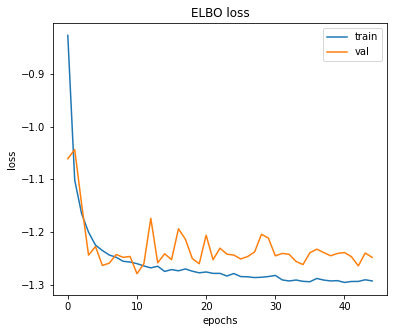

In [76]:
#Elbo loss plot
loss_plot(elbo_loss_train, elbo_loss_eval, "ELBO loss")

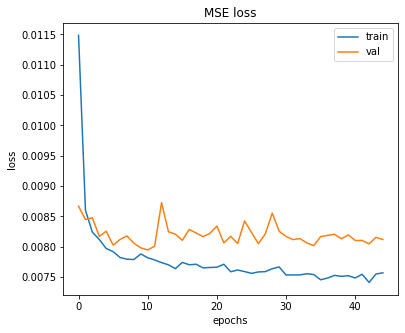

In [77]:
# mse loss plot
loss_plot(mse_loss_train, mse_loss_eval, "MSE loss")

In [78]:
## RMSE for trainig and testing error

yr_train, y_pred_train, _, losses, extra = validation(data_train, data_train)
yr_test, y_pred_test, _,  losses, extra = validation(data_train, data_test)

In [79]:
y_pred_train = y_pred_train[0].detach().cpu().numpy().flatten()
y_pred_test = y_pred_test[0].detach().cpu().numpy().flatten()

In [82]:
MAE = mean_absolute_error(data_train.iloc[:,5], y_pred_train)
RMSE = mean_squared_error(data_train.iloc[:,5], y_pred_train)

print("MAE for traing data = ", MAE)
print("RMSE for trainig data = ", RMSE**0.5)

MAE for traing data =  0.053922238417574306
RMSE for trainig data =  0.09029139766280682


In [83]:
r2 = r2_score(data_train['N'], y_pred_train)
r2

0.17415684063139691

In [85]:
r2 = r2_score(data_test['N'], y_pred_test)
r2

0.15830626805734882

In [87]:
MAE = mean_absolute_error(data_test.iloc[:,5], y_pred_test)
RMSE = mean_squared_error(data_test.iloc[:,5], y_pred_test)

print("MAE for test data = ", MAE)
print("RMSE for test data = ", RMSE**0.5)

MAE for test data =  0.05395590002104137
RMSE for test data =  0.09177640152569776


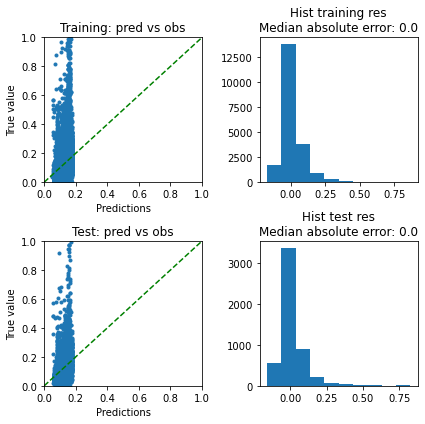

In [89]:
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.plot(y_pred_train, data_train['N'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0, 1], [0, 1], 'g--')
plt.ylim(0, 1)
plt.xlim(0,1)
plt.subplot(222)
plt.hist(yr_train)
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(yr_train))))
plt.subplot(223)
plt.plot(y_pred_test, data_test['N'], '.')
plt.plot([0,1], [0,1], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,1)
plt.xlim(0,1)
plt.subplot(224)
plt.hist(yr_test)
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(yr_test))))
plt.tight_layout()

## ordinary kriging

In [36]:
from pykrige.ok import OrdinaryKriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 0.012415274318568679
Full Sill: 0.01575706661036989
Range: 2.6004818332546926
Nugget: 0.0033417922918012105 



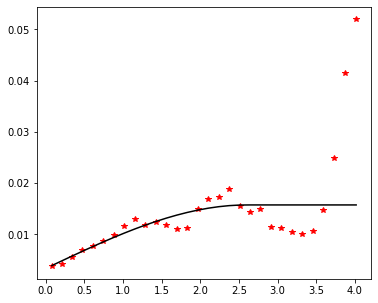

Calculating statistics on variogram model fit...


In [93]:
model = OrdinaryKriging(x=data_train['lon'], y=data_train['lat'], z=data_train['N'], verbose=True,
                enable_plotting=True, nlags=30, weight=True, variogram_model='spherical')


In [94]:
# data_train_ypred = model.execute(style='points',xpoints=data_train['Longitude'], ypoints=data_train['Latitude'] )[0].data
# data_train_residual = data_train['Scaled N'] - data_train_ypred
data_test_ypred = model.execute(style='points', xpoints=data_test['lon'], ypoints=data_test['lat'] )[0].data
data_test_residual = data_test['N'] - data_test_ypred

Executing Ordinary Kriging...



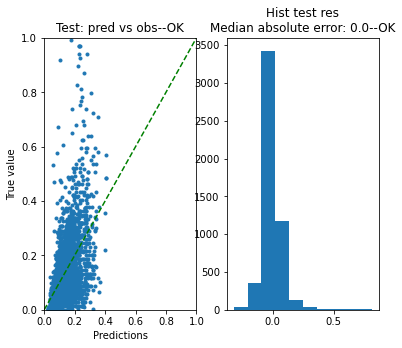

In [95]:
plt.subplot(121)
plt.plot(data_test_ypred, data_test['N'], '.')
plt.plot([0,1], [0,1], 'g--')
plt.title('Test: pred vs obs--OK')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,1)
plt.xlim(0,1)
plt.subplot(122)
plt.hist(data_test_residual)
plt.title('Hist test res\nMedian absolute error: {:.1f}--OK'.format(np.median(np.abs(data_test_residual))))
plt.show()

In [96]:
r2_ok = r2_score(data_test['N'], data_test_ypred)
r2_ok

0.32424537802461706

In [97]:
MAE = mean_absolute_error(data_test['N'], data_test_ypred)
RMSE = mean_squared_error(data_test['N'],data_test_ypred)

print("MAE for test data for Ordinary kriging = ", MAE)
print("RMSE for testing data for Ordinary Kriging = ", RMSE**0.5)

MAE for test data for Ordinary kriging =  0.0498376815275379
RMSE for testing data for Ordinary Kriging =  0.0822334462834148


### Benchmark with KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(data_train[['lon', 'lat']], data_train['N']) 
print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
knn_prediction = nn_model.predict(data_test[['lon', 'lat']])
knn_residual = data_test['N'] - knn_prediction

In [ ]:
r2_knn = r2_score(data_test['N'], knn_prediction)
r2_knn

In [ ]:
MAE = mean_absolute_error(data_test['N'], knn_prediction)
RMSE = mean_squared_error(data_test['N'],knn_prediction)

print("MAE for test data for KNN = ", MAE)
print("RMSE for testing data for KNN = ", RMSE**0.5)

In [ ]:
plt.subplot(121)
plt.plot(knn_prediction, data_test['N'], '.')
plt.plot([0,1], [0,1], 'g--')
plt.title('Test: pred vs obs--OK')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,1)
plt.xlim(0,1)
plt.subplot(122)
plt.hist(knn_residual)
plt.title('Hist test res\nMedian absolute error: {:.1f}--OK'.format(np.median(np.abs(knn_residual))))
plt.show()

In [ ]:
import shapely
from shapely.geometry import Point, MultiPoint

In [ ]:
ls = []
for i in range(len(data)):
    ls.append(Point(data['Longitude'][i], data['Latitude'][i]))
data['geometry'] = ls

In [ ]:
data.head()

In [ ]:
import geopandas as gpd

In [ ]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry'])
        geo_df = geo_df.set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step


In [ ]:
mpt = MultiPoint(list(data.geometry))
convex_hull = mpt.convex_hull.buffer(0.5)
sampler = RegularGridSampler(convex_hull, x_interval=0.02, y_interval=0.02)
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(8,8))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(data['Longitude'], data['Latitude'], 'r.')
plt.title('Sampled grid')
plt.show()

In [ ]:
grid_points.head()

In [ ]:
# plot_grid(grid_points, )

In [ ]:
data.head()

In [ ]:
grid_points.head()

In [ ]:
mean

In [ ]:
def eval_grid(grid_points, data, model_np):
    
    cols = ['y', 'x']
    
    target_x = grid_points.copy()[cols]
    target_x.rename(columns ={'y':'Latitude', 'x':'Longitude'}, inplace = True)
#     print(target_x)
    target_x-=mean#[['x', 'y']]
    target_x/=std#[['x', 'y']]

    df = data.drop(columns=['geometry']).copy()
    df-=mean
    df/=std
    context_x = df.drop(columns=['Scaled N'])
    context_y = df['Scaled N']
    
    print(target_x.shape)
    print(target_x.mean(0))
    print(target_x.std(0))
    print(context_x.shape)

    context_x = torch.from_numpy(context_x.values).float()[None, :]
    context_y = torch.from_numpy(context_y.values).float()[None, :, None]
    target_x = torch.from_numpy(target_x.values).float()[None, :]

    # Make predictions
    model_np.eval()
    with torch.no_grad():

        y_pred, losses, extra = model_np.forward(context_x, context_y, target_x)
    return yr, y_pred, losses, extra 

# for col in allow_columns:
#     if col not in grid_points:
#         grid_points[col]=norm_mean[col]

yr, y_pred, losses, extra  = eval_grid(grid_points, data, Regressor)


In [ ]:
stdv = extra.scale[0, :, 0] * 1
loc = extra.loc[0, :, 0] * 1
stdv *= std['Scaled N']
loc *= std['Scaled N']
loc += mean['Scaled N']

In [ ]:
# import geopandas

In [ ]:
def plot_grid(grid_points, prediction, title):
#     gdf = grid_points.copy()
#     grid_points = geopandas.GeoDataFrame(gdf, geometry=geopandas.points_from_xy(gdf.x, gdf.y))
    grid_points['prediction'] = prediction
    grid_points_gpd = grid_points.set_geometry('geometry')    
    grid_points_gpd.crs = {'init':'epsg:28992'}
    grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
    grid_points_gpd['long'] = grid_points_gpd.geometry.apply(lambda x: x.x)
    grid_points_gpd['lat'] = grid_points_gpd.geometry.apply(lambda x: x.y)
    
    grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
    grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
    grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]
    plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
                 grid_points_pivot.values,20,cmap='GnBu', vmin=0, vmax=1)
    plt.scatter(data['Longitude'], data['Latitude'], c=data['Scaled N'], cmap='GnBu', vmin=0, vmax=1)
    plt.plot(data['Longitude'], data['Latitude'], '.', ms=1)
    plt.title(title)
    plt.colorbar()
    
    return grid_points_pivot.values

In [ ]:
z_np =plot_grid(grid_points, (loc)*1.0, title="NP grid values ")

In [ ]:
z = plot_grid(grid_points, (loc-0.5*stdv)*1.0, title="NP grid values (-0.5 std)")

In [ ]:
z= plot_grid(grid_points, (loc+0.5*stdv)*1.0, title="NP grid values (+.5 std)")

In [ ]:
grid_points.head()

In [ ]:
temp = grid_points.copy()
temp.rename(columns ={'x':'Longitude', 'y':'Latitude', 'Prediction':'Scaled N'}, inplace = True)
temp.head()

In [ ]:
temp.rename(columns ={'prediction':'Scaled N'}, inplace = True)

In [ ]:
# temp.isna()

In [ ]:
op = pd.concat([pd.DataFrame(temp),temp2] )

In [ ]:
op.drop(columns =['geometry'], inplace = True)
op.drop_duplicates(['Longitude', 'Latitude'], inplace = True)
op.head()

In [ ]:
op.to_csv("interpolated.csv")